In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

### Braidz Reading Functions

In [55]:
import glob
import os
import pathlib
import zipfile
import pyarrow.csv as pv
import pyarrow as pa
import gzip
import pandas as pd
from tqdm import tqdm
from typing import Dict, Tuple, Optional, Literal
import logging


def read_csv_pyarrow(file_obj) -> Optional[pd.DataFrame]:
    """
    Read a CSV file using pyarrow and convert it to a pandas DataFrame.

    Args:
        file_obj (file-like object): The file-like object containing the CSV data.

    Returns:
        Optional[pd.DataFrame]: The pandas DataFrame containing the CSV data, or None if the file is invalid.

    Raises:
        pa.ArrowInvalid: If the file is invalid and cannot be read by pyarrow.

    """
    try:
        table = pv.read_csv(
            file_obj, read_options=pv.ReadOptions(skip_rows_after_names=1)
        )
        return table.to_pandas()
    except pa.ArrowInvalid:
        return None


def read_csv_pandas(file_obj) -> Optional[pd.DataFrame]:
    """
    Reads a CSV file using pandas and returns a DataFrame.

    Args:
        file_obj (str or file-like object): The file path or file-like object to read.

    Returns:
        Optional[pd.DataFrame]: A DataFrame containing the data from the CSV file, or None if the file is empty.

    Raises:
        pd.errors.EmptyDataError: If the file is empty.
    """
    try:
        return pd.read_csv(file_obj, comment="#")
    except pd.errors.EmptyDataError:
        return None


def _read_from_file(
    filename: str, parser: Literal["pandas", "pyarrow"] = "pyarrow"
) -> Tuple[Optional[pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    Reads data from a .braidz file using either PyArrow or pandas for CSV parsing.

    This function opens a .braidz file, reads the 'kalman_estimates.csv.gz' file into a pandas DataFrame,
    and also reads any other .csv files present in the .braidz file into a dictionary of pandas DataFrames.

    Parameters:
    filename (str): The path to the .braidz file.
    parser (str): The parser to use for reading CSV files. Either "pandas" or "pyarrow". Default is "pyarrow".

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    if parser not in ["pandas", "pyarrow"]:
        raise ValueError("parser must be either 'pandas' or 'pyarrow'")

    filepath = pathlib.Path(filename)
    csv_s: Dict[str, pd.DataFrame] = {}

    read_csv = read_csv_pyarrow if parser == "pyarrow" else read_csv_pandas

    with zipfile.ZipFile(file=filepath, mode="r") as archive:
        print(f"Reading {filename} using {parser}")

        # Read kalman_estimates.csv.gz
        try:
            with archive.open("kalman_estimates.csv.gz") as file:
                if parser == "pandas":
                    df = read_csv(gzip.open(file, "rt"))
                else:  # pyarrow
                    with gzip.open(file, "rb") as unzipped:
                        df = read_csv(unzipped)
            if df is None or df.empty:
                return None, None
        except KeyError:
            print(f"kalman_estimates.csv.gz not found in {filename}")
            return None, None

        # Read other CSV files
        csv_files = [csv for csv in archive.namelist() if csv.endswith(".csv")]
        for csv_file in csv_files:
            key, _ = os.path.splitext(csv_file)
            try:
                csv_s[key] = pd.read_csv(archive.open(csv_file))
            except pd.errors.EmptyDataError:
                continue

    return df, csv_s


def _read_from_folder(filename: str) -> tuple[pd.DataFrame, dict]:
    """
    Reads data from a folder.

    This function reads the 'kalman_estimates.csv.gz' file from a specified folder into a pandas DataFrame,
    and also reads any other .csv files present in the folder into a dictionary of pandas DataFrames.

    Parameters:
    filename (str): The path to the folder.

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    df = pd.read_csv(
        os.path.join(filename, "kalman_estimates.csv.gz"),
        comment="#",
        compression="gzip",
    )
    csv_files = glob.glob(f"{filename}/*.csv")

    csv_s = {}
    for csv_file in csv_files:
        key, _ = os.path.splitext(csv_file)
        try:
            csv_s[key] = pd.read_csv(csv_file)
        except pd.errors.EmptyDataError:
            continue

    return df, csv_s


def _extract_to_folder(filename: str, read_extracted: bool = False) -> str:
    """
    Extracts a .braidz file to a folder.

    This function extracts all the files from a .braidz file to a folder with the same name as the .braidz file.
    If the folder already exists, it does nothing. If read_extracted is True, it also reads the extracted files.

    Parameters:
    filename (str): The path to the .braidz file.
    read_extracted (bool): Whether to read the extracted files. Default is False.

    Returns:
    str: The path to the folder where the files were extracted.
    """
    extract_path = os.path.splitext(filename)[0]
    if not os.path.exists(extract_path):
        os.mkdir(extract_path)
    # else:
    # return _read_from_folder(extract_path)

    with zipfile.ZipFile(filename, "r") as zip_ref:
        # Get the total number of files inside the zip
        total_files = len(zip_ref.infolist())

        # Loop through each file, extract it, and update the tqdm progress bar
        with tqdm(total=total_files, unit="file") as pbar:
            for member in zip_ref.infolist():
                # Extract a single file
                zip_ref.extract(member, extract_path)
                pbar.update(1)

    if read_extracted:
        return _read_from_folder(extract_path)

    return extract_path


def validate_file(filename: str):
    """
    Validates that the file is of the expected type.

    Parameters:
    filename (str): The path to the file.

    Raises:
    ValueError: If the file is not of the expected type.
    """
    if not filename.endswith(".braidz"):
        raise ValueError(f"File {filename} is not of the expected '.braidz' type")


def validate_directory(filename: str):
    """
    Validates that the directory contains the expected files.

    Parameters:
    filename (str): The path to the directory.

    Raises:
    ValueError: If the directory does not contain the expected files.
    """
    if not any(fname.endswith(".csv.gz") for fname in os.listdir(filename)):
        raise ValueError(f"Directory {filename} does not contain any '.csv.gz' files")


def read_braidz(
    filename: str, extract_first: bool = False
) -> tuple[pd.DataFrame, dict]:
    """
    Reads data from a .braidz file or a folder.

    This function reads the 'kalman_estimates.csv.gz' file from a .braidz file or a folder into a pandas DataFrame,
    and also reads any other .csv files present into a dictionary of pandas DataFrames.
    If extract_first is True, it first extracts the .braidz file to a folder.

    Parameters:
    filename (str): The path to the .braidz file or folder.
    extract_first (bool): Whether to first extract the .braidz file to a folder. Default is False.

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    if os.path.isfile(filename):
        validate_file(filename)
        if extract_first:
            df, csvs = _extract_to_folder(filename, read_extracted=True)
        else:
            df, csvs = _read_from_file(filename)

    elif os.path.isdir(filename):
        validate_directory(filename)
        df, csvs = _read_from_folder(filename)

    else:
        raise FileNotFoundError(f"Path {filename} does not exist")

    return df, csvs


def read_multiple_braidz(files: list | str, root_folder: str | None = None) -> dict:
    """
    Reads data from multiple .braidz files and combines them into one DataFrame.
    Create a new column `unique_obj_id` with the index of the dataframe appended to the original `obj_id`.
    """

    if not isinstance(files, list):
        files = [files]

    dfs = []
    stims = []
    optos = []

    for i, filename in enumerate(files):
        if root_folder is not None:
            filename = os.path.join(root_folder, filename)

        # read entire file
        df, csvs = read_braidz(filename)

        # update dfs
        df["exp_num"] = i
        df["unique_obj_id"] = f"{i}_" + df["obj_id"].astype(str)

        dfs.append(df)

        # update stims
        if "stim" in csvs:
            stim = csvs["stim"]
            stim["unique_obj_id"] = f"{i}_" + stim["obj_id"].astype(str)
            stim["exp_num"] = i
            stims.append(stim)

        # update optos
        if "opto" in csvs:
            opto = csvs["opto"]
            opto["unique_obj_id"] = f"{i}_" + opto["obj_id"].astype(str)
            opto["exp_num"] = i
            optos.append(opto)

    # combine all dataframes, if they exist
    if len(dfs) > 0:
        dfs = pd.concat(dfs, ignore_index=True)

    if len(stims) > 0:
        stims = pd.concat(stims, ignore_index=True)
    if len(optos) > 0:
        optos = pd.concat(optos, ignore_index=True)

    data = {"df": dfs, "stim": stims, "opto": optos}
    return data


### Data processing functions

In [65]:
def calculate_angular_velocity(df, dt=0.01):
    theta = np.arctan2(
        df.yvel.values, df.xvel.values
    )  # get the arctan2 based on velocity direction
    theta_unwrap = np.unwrap(theta)  # unwrap the angles
    angular_velocity = np.gradient(theta_unwrap, dt)  # get the derivative
    return angular_velocity


def calculate_linear_velocity(df):
    linear_velocity = np.sqrt(df.xvel.values**2 + df.yvel.values**2)
    return linear_velocity


def smooth_sg(df, columns=["xvel", "yvel"]):
    # Create a copy of the DataFrame
    df = df.copy()

    # coerce into list if we pass only a string
    if isinstance(columns, str):
        columns = [columns]

    # loop over the columns and smooth each one, while keeping a copy of the original
    for col in columns:
        df[f"{col}_original"] = df[col].copy()
        df[col] = savgol_filter(df[col], window_length=21, polyorder=3)
    return df


def calculate_heading_change(
    trajectories,
    central_point=50,
    dt_before=10,
    dt_after=50,
):
    """
    Calculate the change in heading for each trajectory.

    Args:
        trajectories (np.array): Numpy array of shape [n, 150, 3] containing n trajectories.
        central_point (int, optional): Index of the central point (0-149). Defaults to 50.
        dt_before (int, optional): Number of points to consider before the central point. Defaults to 10.
        dt_after (int, optional): Number of points to consider after the central point. Defaults to 50.

    Returns:
        np.array: Numpy array of shape [n] containing heading changes in radians.
    """
    n = trajectories.shape[0]
    heading_changes = np.zeros(n)

    for i in range(n):
        trajectory = trajectories[i]

        before_point = max(0, central_point - dt_before)
        after_point = min(149, central_point + dt_after)

        before_vector = trajectory[central_point, :2] - trajectory[before_point, :2]
        after_vector = trajectory[after_point, :2] - trajectory[central_point, :2]

        before_angle = np.arctan2(before_vector[1], before_vector[0])
        after_angle = np.arctan2(after_vector[1], after_vector[0])

        heading_change = after_angle - before_angle

        heading_change = (heading_change + np.pi) % (2 * np.pi) - np.pi

        heading_changes[i] = heading_change

    return heading_changes


def get_data(df, opto, n_before=50, n_after=100):
    # intialize counter for how many opto frames we've skipped
    skip_opto_idx = 0
    skip_oob = 0

    # initialize empty lists to store data
    angular_velocity_list = []
    linear_velocity_list = []
    exp_num_list = []
    trajectories = []

    # we iterate over each row in the opto dataframe
    # and extract the obj_id, exp_num, and frame
    # this allows us to select the correct object in the main dataframe
    for idx, row in opto.iterrows():
        obj_id = row["obj_id"]
        exp_num = row["exp_num"]
        frame = row["frame"]
        
        if row["sham"]:
            # skip sham trials
            continue
            
        # and then extract the correct group from the main dataframe
        grp = df[(df.obj_id == obj_id) & (df.exp_num == exp_num)].copy()

        # next, we find the opto activation frame in the group df
        # the `try-except` block is used since sometimes there's a weird error where the frame from the opto array
        # is not found in the main dataframe; in that case, we skip that one
        try:
            opto_idx = np.where(grp.frame == frame)[0][0]
        except IndexError:
            #print(" could not find the opto frame in the subgroup; skipping ")
            skip_opto_idx += (
                1  # a counter to keep track of how many objects were skipped
            )
            continue

        # now we want to calculate the index before and after the opto
        start_idx = opto_idx - n_before
        end_idx = opto_idx + n_after

        # now we check if these are out of bounds,
        # if they are, we skip them
        if start_idx < 0 or end_idx >= len(grp):
            #print(" start or end index are out of bounds; skipping.")
            skip_oob += 1
            continue

        # now we want to apply some smoothing on the xvel and yvel columns
        # this helps remove some tracking noise
        grp = smooth_sg(grp, ["xvel", "yvel", "x", "y", "z"])

        # now calculate the angular and linear velocity
        grp["angular_velocity"] = calculate_angular_velocity(grp)
        grp["linear_velocity"] = calculate_linear_velocity(grp)

        # and smooth again
        grp = smooth_sg(grp, "angular_velocity")

        # Create a new copy after all modifications
        grp = grp.copy()

        # extract the angular velocity and linear velocity columns
        angular_velocity = grp.angular_velocity.to_numpy()
        linear_velocity = grp.linear_velocity.to_numpy()

        # also extract the xyz columns
        position = grp[["x","y","z"]].to_numpy()

        # and extract the window around the opto_idx
        angular_velocity_window = angular_velocity[start_idx:end_idx]
        linear_velocity_window = linear_velocity[start_idx:end_idx]
        position_window = position[start_idx:end_idx, :]

        # and append to list we return
        angular_velocity_list.append(angular_velocity_window)
        linear_velocity_list.append(linear_velocity_window)
        trajectories.append(position_window)
        exp_num_list.append(
            exp_num
        )  # we also keep the exp_num so we can separate them later

    # convert all of the lists to a numpy array
    angular_velocity_as_numpy_arry = np.array(angular_velocity_list)
    linear_velocity_as_numpy_arry = np.array(linear_velocity_list)
    exp_num_as_numpy_arry = np.array(exp_num_list)
    trajectories_as_numpy_array = np.array(trajectories)

    print(
        f"Skipped {skip_opto_idx} opto frames that could not be found in the main dataframe"
    )
    print(f"Skipped {skip_oob} opto frames that were out of bounds")

    # and return all of them
    return (
        angular_velocity_as_numpy_arry,
        linear_velocity_as_numpy_arry,
        trajectories_as_numpy_array,
        exp_num_as_numpy_arry,
    )


### Read braidz files

`read_multiple_braidz` reads and concatenates all the data from multiple `braidz` files.

To keep track of different experiments, it append the experiment number to each `obj_id`, as well as adding a `exp_num` column to the dataframe.

(you can also read multiple different groups by repeating the same operation for different groups - for example, all the J73 files, all the J74 files, etc
just make sure to save each group under a different variable name)


In [57]:
files_to_load = ["20240915_140001.braidz", "20240913_141235.braidz"]
data = read_multiple_braidz(
    files_to_load, root_folder="/home/buchsbaum/mnt/md0/Experiments/"
)

Reading /home/buchsbaum/mnt/md0/Experiments/20240915_140001.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240913_141235.braidz using pyarrow


In [ ]:
# j73_files_to_load = [...]
# j73_data = read_multiple_braidz(j73_files_to_load, root_folder="/home/buchsbaum/mnt/md0/Experiments/")

# j74_files_to_load = [...]
# j74_data = read_multiple_braidz(j74_files_to_load, root_folder="/home/buchsbaum/mnt/md0/Experiments/")

# etc...

`data` is a `dict` object containing three keys:
- `df` - the tracking data for all the experiments.
- `stim` - the stimulus information (if available, otherwise empty)
- `opto` - the optogenetic information (if available, otherwise empty)

As we can see, in this case, these are opto experiments; therefore, the `stim` array is empty. The `opto` array has 170 rows, corrosponding to 170 activations.

In [66]:
df = data["df"]
stim = data["stim"]
opto = data["opto"]

print("df rows: ", len(df))
print("stim rows: ", len(stim))
print("opto rows: ", len(opto))

df rows:  24416345
stim rows:  0
opto rows:  170


We use the custom function `get_data` which extract the:
- angular velocity (numpy array, with shape [n trajectories x 150])
- linear velocity (same)
- positions (list of numpy arrays, each with shape [n trajectories, 150 frames, 3 axis]) 
- and experiment number

In [67]:
angular_velocity, linear_velocity, positions, exp_list = get_data(
    df, opto, n_before=50, n_after=100
)

Skipped 0 opto frames that could not be found in the main dataframe
Skipped 13 opto frames that were out of bounds


We can now plot each experiment separately, by indexing via exp_list

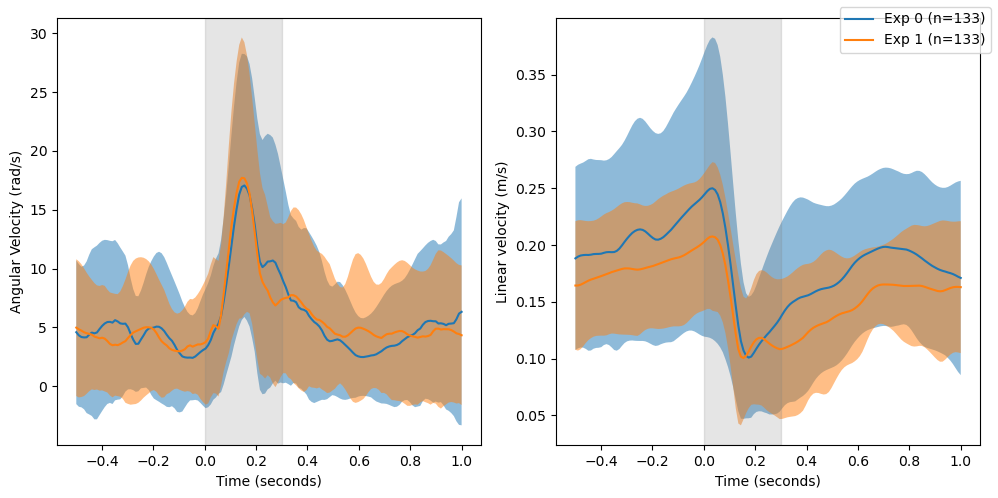

In [68]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

X = np.linspace(-0.5, 1.0, 150) # in here I define the X axis as time in seconds instead of frames, where time 0 is the opto frame

for exp_num in np.unique(exp_list):
    # extract the boolean index for experiment `exp_num`
    current_exp_num = exp_list == exp_num

    # extract the angular and linear velocity for this experiment
    current_angular_velocity = angular_velocity[current_exp_num]
    current_linear_velocity = linear_velocity[current_exp_num]

    # get the mean and std for each
    current_angular_velocity_mean = np.nanmean(np.abs(current_angular_velocity), axis=0)
    current_angular_velocity_std = np.nanstd(np.abs(current_angular_velocity), axis=0)

    current_linear_velocity_mean = np.nanmean(np.abs(current_linear_velocity), axis=0)
    current_linear_velocity_std = np.nanstd(np.abs(current_linear_velocity), axis=0)

    # plot mean
    axs[0].plot(
        X,
        current_angular_velocity_mean,
        label=f"Exp {exp_num} (n={len(current_exp_num)})",
    )
    
    # plot std
    axs[0].fill_between(
        X,
        current_angular_velocity_mean - current_angular_velocity_std,
        current_angular_velocity_mean + current_angular_velocity_std,
        alpha=0.5,
    )

    axs[0].set_xlabel("Time (seconds)")
    axs[0].set_ylabel("Angular Velocity (rad/s)")

    axs[1].plot(X, current_linear_velocity_mean)
    axs[1].fill_between(
        X,
        current_linear_velocity_mean - current_linear_velocity_std,
        current_linear_velocity_mean + current_linear_velocity_std,
        alpha=0.5,
    )
    axs[1].set_xlabel("Time (seconds)")
    axs[1].set_ylabel("Linear velocity (m/s)")

# add a shaded region for all plots
for ax in axs:
    ax.axvspan(0, 0.3, color="gray", alpha=0.2)

plt.tight_layout()
fig.legend()
plt.show()

Or we can plot the average of all of them at the same time

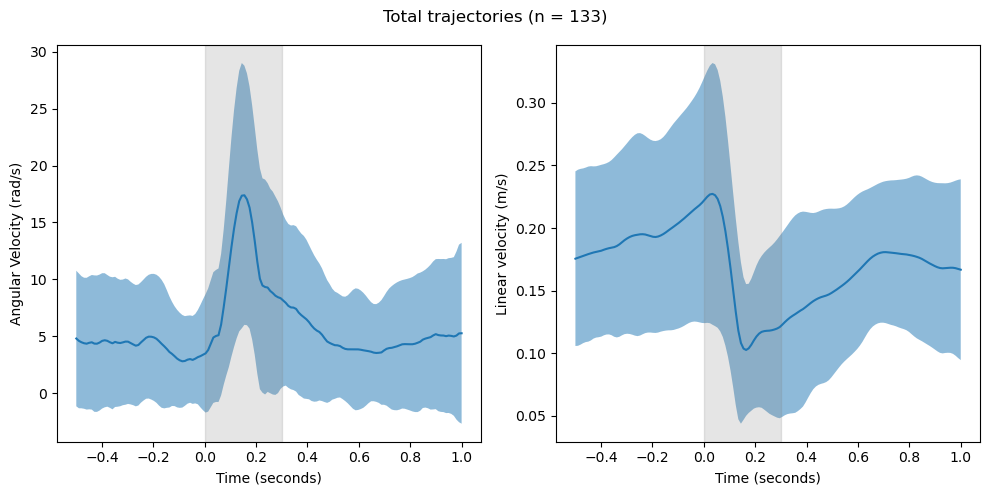

In [69]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
X = np.linspace(-0.5, 1.0, 150)

# get the mean and std for each
current_angular_velocity_mean = np.nanmean(np.abs(angular_velocity), axis=0)
current_angular_velocity_std = np.nanstd(np.abs(angular_velocity), axis=0)

current_linear_velocity_mean = np.nanmean(np.abs(linear_velocity), axis=0)
current_linear_velocity_std = np.nanstd(np.abs(linear_velocity), axis=0)

axs[0].plot(X, current_angular_velocity_mean)
axs[0].fill_between(
    X,
    current_angular_velocity_mean - current_angular_velocity_std,
    current_angular_velocity_mean + current_angular_velocity_std,
    alpha=0.5,
)

axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Angular Velocity (rad/s)")

axs[1].plot(X, current_linear_velocity_mean)
axs[1].fill_between(
    X,
    current_linear_velocity_mean - current_linear_velocity_std,
    current_linear_velocity_mean + current_linear_velocity_std,
    alpha=0.5,
)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Linear velocity (m/s)")

for ax in axs:
    ax.axvspan(0, 0.3, color="gray", alpha=0.2)

plt.suptitle(f"Total trajectories (n = {len(angular_velocity)})")
plt.tight_layout()
plt.show()

If we want to get the max or minimum value for each array using numpy, and make a scatterplot

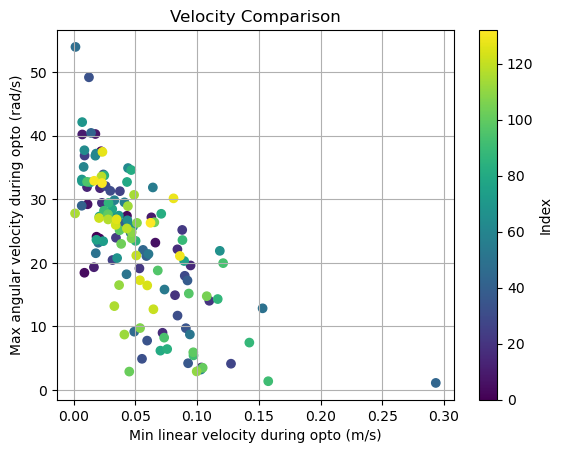

In [70]:
# Define the slice range as a variable for reusability
slice_start, slice_end = 50, 81

# Function to process velocity slices
def get_minmax_abs_values(data, start, end, operation='max'):
    relevant_slice = data[:, start:end]
    abs_values_slice = np.abs(relevant_slice)
    
    if operation == 'max':
        return np.max(abs_values_slice, axis=1)
    elif operation == 'min':
        return np.min(abs_values_slice, axis=1)
    else:
        raise ValueError("Unsupported operation: Use 'max' or 'min'")

# Compute max abs values for angular velocity
max_abs_values_angular_velocity = get_minmax_abs_values(angular_velocity, slice_start, slice_end, operation='max')

# Compute min abs values for linear velocity
min_abs_values_linear_velocity = get_minmax_abs_values(linear_velocity, slice_start, slice_end, operation='min')

# Prepare the index for coloring
index = np.arange(len(max_abs_values_angular_velocity))

# Plotting the data
fig, ax = plt.subplots()
scatter = ax.scatter(min_abs_values_linear_velocity, max_abs_values_angular_velocity, c=index, cmap='viridis')
ax.set_xlabel("Min linear velocity during opto (m/s)")
ax.set_ylabel("Max angular velocity during opto (rad/s)")
ax.set_title("Velocity Comparison")
ax.grid(True)
fig.colorbar(scatter, ax=ax, label="Index")
plt.show()


We can use `calculate_heading_change` to calculate the change in heading before and after the opto stimulus, for each trajectory.
We can then plot this as a histogram.

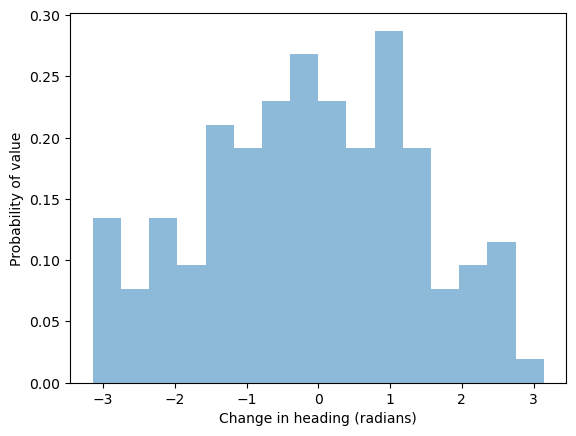

In [71]:
headings_change = calculate_heading_change(positions, central_point=50, dt_before=10, dt_after=50)

fig = plt.figure()
plt.hist(headings_change, bins=16, range=(-np.pi, np.pi), density=True, alpha=0.5)
plt.xlabel("Change in heading (radians)")
plt.ylabel("Probability of value")
plt.show()